# OpSim -- the updated simulation notebook

## About

This notebook is running the LuSEE-Night simulations, as a part of "Conops" R&D. Notes:
* Celestial bodies: data is read from prefabricated files in HDF5 format, containing the pre-calculated Sun and the two Satellites' positions as time series.
* The time axis in the time series is defined in units of _MJD_
* The _lunar clock_ is an auxiliary variable which defines a "lunar day" as 24 "lunar hours", used mainly to refer to the temperature data obtained from the __Diviner__


In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  os, sys
import  matplotlib.pyplot as plt

try:
    luseepy_path=os.environ['LUSEEPY_PATH']
    print(f'''The LUSEEPY_PATH is defined in the environment: {luseepy_path}, will be added to sys.path''')
    sys.path.append(luseepy_path)
except:
    print('The variable LUSEEPY_PATH is undefined, will rely on PYTHONPATH')

try:
    luseeopsim_path=os.environ['LUSEEOPSIM_PATH']
    print(f'''The LUSEEOPSIM_PATH is defined in the environment: {luseeopsim_path}, will be added to sys.path''')
    sys.path.append(luseeopsim_path)
except:
    print('The variable LUSEEOPSIM_PATH is undefined, will rely on PYTHONPATH')
    sys.path.append('../')  # Add parent dir to path, to ensure at least basic functionality in the notebook

for path_part in sys.path:
    if path_part!='': print(f'''{path_part}''')

The variable LUSEEPY_PATH is undefined, will rely on PYTHONPATH
The variable LUSEEOPSIM_PATH is undefined, will rely on PYTHONPATH
/user/luseepy
/user/refspec/cppyy
/usr/local/lib/python310.zip
/usr/local/lib/python3.10
/usr/local/lib/python3.10/lib-dynload
/usr/local/lib/python3.10/site-packages
../


In [2]:

import  lusee   # Core lusee software
import simpy
from    nav import * # Astro/observation wrapper classes
from    utils.timeconv import *
#from notebooks_git import *

In [3]:
import  sim # Main simulation module, which contains the Simulator class
from    sim import Simulator

chatty = False
if chatty:
    print("---------------------------------- PATH ----------------------------------------")
    for path_part in sys.path:
        if path_part!='': print(f'''{path_part}''')

    print('--------------------------------- VERSIONS -------------------------------------')
    print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

# Define paths in one place:
#orbitals    = "../data/orbitals/20260110-20270115.hdf5" ## old
orbitals    = "../data/orbitals/20260110-20270116.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

#comtable    = "../config/comtable-20260110-20270115.yml"
#comtable    = "./simulator_log.yml"
comtable = None

initial_time=2
until=4600
#2780

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until, verbose=True)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

if chatty:
    print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}, Sun Alt: {smltr.sun.alt[initial_time]}''')
    print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')
    print(smltr.schedule)


Shape of the data payload: (35450, 9)
dimensions None
Comm configuration keys: dict_keys(['adaptable_rate', 'if_adaptable', 'if_fixed'])
Created a Battery with initial charge: 432000.0, capacity: 862098.3468
Created a SSD with initial fill: 0.0, capacity: 32000000.0
Lander pitch, roll, yaw: [0. 0. 0.]
Adding panel EPanel with normal [1. 0. 0.], 	efficiency 1.0, and surface area 0.1565
Adding panel WPanel with normal [-1.  0.  0.], 	efficiency 1.0, and surface area 0.1565
Adding panel TPanel with normal [0. 0. 1.], 	efficiency 1.0, and surface area 0.313


/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [4]:
smltr.power_info()

Mode:  science
     Device: PDU          : 0.90 W
     Device: DCB          : 2.00 W
     Device: preamp       : 0.90 W
     Device: spectrometer : 11.50 W
     Device: PFPS         : 7.48 W
     Device: HEATER       : 0.00 W
     Device: UT           : 0.00 W
     Device: PCDU         : 0.80 W
   Total power: 23.6 W

Mode:  maint
     Device: PDU          : 0.90 W
     Device: DCB          : 2.00 W
     Device: preamp       : 0.90 W
     Device: spectrometer : 8.00 W
     Device: PFPS         : 5.91 W
     Device: HEATER       : 0.00 W
     Device: UT           : 5.30 W
     Device: PCDU         : 1.50 W
   Total power: 24.5 W

Mode:  powersave
     Device: PDU          : 0.90 W
     Device: DCB          : 2.00 W
     Device: preamp       : 0.90 W
     Device: spectrometer : 0.00 W
     Device: PFPS         : 2.30 W
     Device: HEATER       : 1.00 W
     Device: UT           : 0.00 W
     Device: PCDU         : 0.80 W
   Total power:  7.9 W



---

Visualize power consumption for each device, in different modes, in a bar chart (optional)

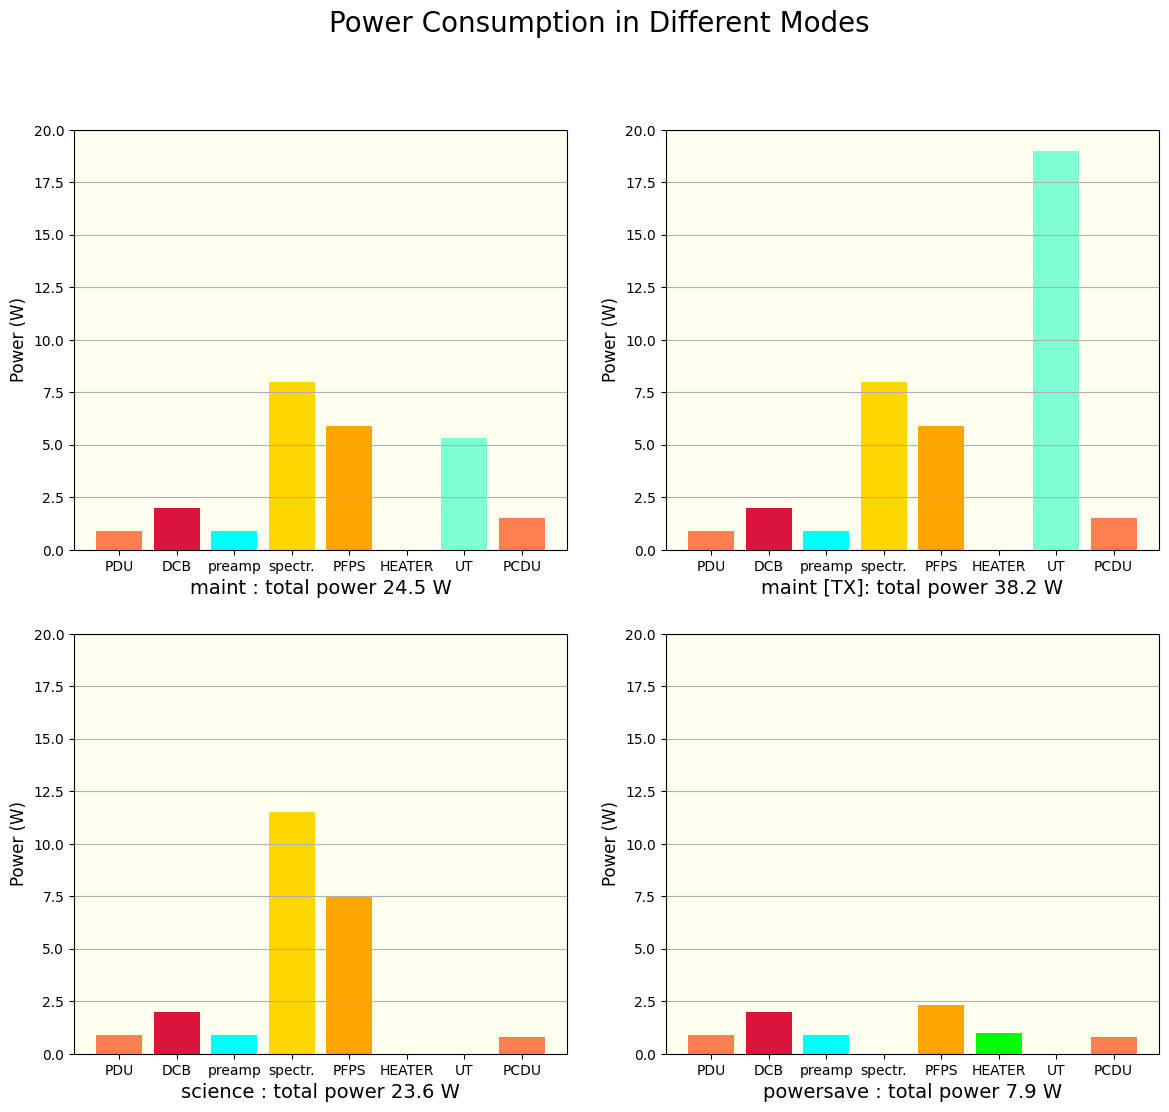

In [5]:
pwr_science = smltr.power_out(mode='science', return_dict=True)
device_names = list(pwr_science.keys())

for i in range(len(device_names)):
    if device_names[i]=='spectrometer':
        device_names[i]='spectr.'


fig, plots = plt.subplots(2,2, figsize=(14,12))
fig.suptitle('Power Consumption in Different Modes', fontsize=20)
plt.rcParams["figure.figsize"] = [18., 6.]

clrs = ["coral","crimson", "cyan", "gold", "orange", "lime", "aquamarine"]

mode_list = [('maint',[]), ('maint',['TX']), ('science',[]), ('powersave',[]),  ]
for i,mode_pair in enumerate(mode_list):
    mode, cond = mode_pair
    pwr = list(smltr.power_out(mode = mode, conditions = cond, return_dict=True, get_heat=False).values())
    plots[i//2][i%2].bar(device_names, pwr, color=clrs,   label="Science")
    total_power = sum(pwr)
    tx = '[TX]' if 'TX' in cond else ''
    xlabel = f'{mode} {tx}: total power {total_power:.1f} W'
    plots[i//2][i%2].set_xlabel(xlabel, fontsize=14)

for l in plots:
    for p in l:
        p.set_ylabel('Power (W)', fontsize=12)
        p.set_ylim(0,20)
        p.grid(axis='y')
        p.set_facecolor('ivory')


---

### Run the simulation

In [6]:
# Set verbose if needed:
smltr.verbose = False # True
smltr.simulate(create_command_table=True)
comtable = '/tmp/current-command-table.yml'
smltr.save_record(comtable)


3843.7179460187035 384
The adaptable data rate is calculated as 169.68230090723225
4372.800891664817 385
The adaptable data rate is calculated as 84.89115045361612
4895.234953916798 386
The adaptable data rate is calculated as 84.89115045361612
5393.563602749025 387
The adaptable data rate is calculated as 84.89115045361612
5998.246363236937 432
The adaptable data rate is calculated as 84.89115045361612
6411.585225547234 433
The adaptable data rate is calculated as 84.89115045361612
6790.654102296956 434
The adaptable data rate is calculated as 84.89115045361612
7136.017203710834 435
The adaptable data rate is calculated as 42.495575226808064
7448.530873111572 436
The adaptable data rate is calculated as 42.495575226808064
7729.139865830669 437
The adaptable data rate is calculated as 42.495575226808064
7978.775114371009 438
The adaptable data rate is calculated as 42.495575226808064
3241.3628364641995 470
The adaptable data rate is calculated as 169.68230090723225
3720.5050346768385 4

In [7]:
## now run again with generated command table
comtable = '/tmp/current-command-table.yml'
smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)
smltr.verbose = False # True
smltr.simulate()

dimensions None
Comm configuration keys: dict_keys(['adaptable_rate', 'if_adaptable', 'if_fixed'])
3843.7179460187035 384
The adaptable data rate is calculated as 169.68230090723225
4372.800891664817 385
The adaptable data rate is calculated as 84.89115045361612
4895.234953916798 386
The adaptable data rate is calculated as 84.89115045361612
5393.563602749025 387
The adaptable data rate is calculated as 84.89115045361612
5998.246363236937 432
The adaptable data rate is calculated as 84.89115045361612
6411.585225547234 433
The adaptable data rate is calculated as 84.89115045361612
6790.654102296956 434
The adaptable data rate is calculated as 84.89115045361612
7136.017203710834 435
The adaptable data rate is calculated as 42.495575226808064
7448.530873111572 436
The adaptable data rate is calculated as 42.495575226808064
7729.139865830669 437
The adaptable data rate is calculated as 42.495575226808064
7978.775114371009 438
The adaptable data rate is calculated as 42.495575226808064
3241

In [ ]:
smltr.monitor.data_rate

---

### Plot the results

In [ ]:
mjd = smltr.sun.mjd

fig, plots = plt.subplots(2,2, figsize=(15,10))

fig.suptitle('Simulation', fontsize=20)

plt.rcParams["figure.figsize"] = [18., 6.]
plt.rcParams["figure.autolayout"] = True


ylabels = ['Battery SOC', 'Power drawn by the hardware', 'Data volume stored in SSD', 'Box Temperature [C]']
colors  = ["blue", "red", "orange", "cyan"]
data    = (smltr.monitor.battery_SOC, smltr.monitor.power, smltr.monitor.ssd, smltr.monitor.boxtemp)

mjd = smltr.sun.mjd

xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until] - 1

plots = plots.flatten()

for i in range(4):
    p = plots[i]

    p.plot(mjd, data[i], color=colors[i],   label=ylabels[i])
    p.set_xlabel('Time (MJD)', fontsize=12)
    p.set_ylabel(ylabels[i], fontsize=12)
    p.set_xlim([xlo, xhi])
    p.grid(True)
    p.set_facecolor('ivory')

plt.show()





---

### Optional -- some graphs.



In [ ]:
# OPTIONAL PLOTS

plt.rcParams["figure.figsize"] = [15., 5.]

# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
myLpf = smltr.lpf
myBge = smltr.bge

print(mySun.N)

fig, (p1, p2, p3) = plt.subplots(1,3)

fig.suptitle('The Sun and the Sats', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(myLpf.mjd, myLpf.alt,  color="orange", label="Lpf Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(myLpf.mjd, myLpf.az, color="magenta",label="Lpf Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p3.plot(myLpf.mjd, myLpf.alt,  color="blue", label="Lpf Alt")
p3.plot(myBge.mjd, myBge.alt,  color="orange", label="Bge Alt")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()

p3.grid(True)
_ = p3.legend()
p3.set_xlim(61110,61114)

In [ ]:
# OPTIONAL


plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power,  color="red",    label="Panel power")
plt.xlabel("Time (MJD)")
plt.ylabel("Power (W)")
plt.xlim(61080, 61100)
ax.grid(True)


In [ ]:
mySun.alt.max()/np.pi*180